In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np
import random
from tqdm import tqdm
from torchtext.legacy import data
from termcolor import colored
from torchtext.data.metrics import bleu_score
import pandas as pd
import os
from os import path
import string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import matplotlib.pyplot as plt

In [3]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [1]:
root="/content/drive/MyDrive/IIMAS/aprendizaje profundo/proyecto"

## Exploracion de los datos de los datos

In [4]:
df=pd.read_csv(path.join(root,"spa.txt"),sep="\t", header=None)
df.drop(2,inplace=True,axis=1)
df.dropna(inplace=True)
df.columns=["English","Spanish"]
df= df.sample(frac=1).reset_index(drop=True)
df

,English,Spanish
0,Who's hiding behind the curtain?,¿Quién se esconde tras la cortina?
1,Stop deluding yourself.,Deja de engañarte a ti mismo.
2,"Suddenly, she stopped and looked around.","Repentinamente, se detuvo y miró alrededor."
3,"Tom, do you love me?","Tom, ¿tú me quieres?"
4,Is there life in outer space?,¿Hay vida en el espacio?
...,...,...
128079,That applies to him too.,Eso aplica para él también.
128080,Keep talking.,Continúe hablando.
128081,I felt that the plan was unwise.,Me di cuenta de que el plan no era sensato.
128082,Would you like to contribute to the program?,¿Desea contribuir al programa?


In [5]:
import re
WORD = re.compile(r'\w+')
def tokenizer(text):
    return  WORD.findall(text.lower())

In [6]:
import matplotlib.pyplot as plt

In [11]:
en=df["English"].apply(lambda x: len(tokenizer(x)))
es=df["Spanish"].apply(lambda x: len(tokenizer(x)))

Text(0.5, 1.0, 'English')

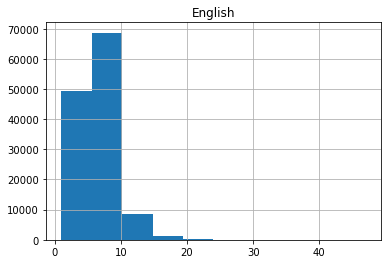

In [17]:
en.hist()
plt.title("English")

Text(0.5, 1.0, 'Spanish')

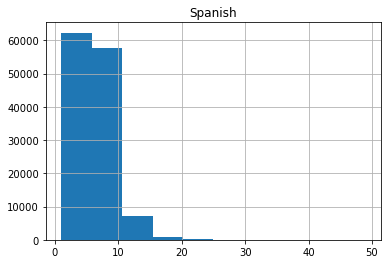

In [18]:
es.hist()
plt.title("Spanish")

## Limpieza y preprocesamiento

In [9]:
def clean(doc):
    exclude = set(string.punctuation + '¡' + '¿') 
    doc = doc.lower()
    doc = doc.replace("i'm", "i am")
    doc = doc.replace("you're", "you are")
    doc = doc.replace("he's", "he is")
    doc = doc.replace("it's", "it is")
    doc = doc.replace("she's", "she is")
    doc = doc.replace("we're", "we are")
    doc = doc.replace("'ve", " have")
    doc = doc.replace("'d", " would")
    doc = doc.replace("don't", "do not")
    doc = doc.replace("didn't", "did not")
    doc = doc.replace("doesn't", "does not")
    doc = doc.replace("'ll", " will")
    doc = doc.replace("won't", " will not")
    doc = doc.replace("what's", " what is")
    doc = doc.replace("shouldn't", " should not")
    doc = doc.replace("isn't", " is not")
    doc = doc.replace("aren't", " are not")
    doc = doc.replace("wouldn't", "would not")
    doc = doc.replace("couldn't", "could not")
    doc = doc.replace("there's", "there is")
    doc = doc.replace("that's", "that is")
    doc = doc.replace("hasn't", "has not")
    doc = doc.replace("haven't", "have not")
    punc_free = ''.join(ch for ch in doc if ch not in exclude)
    return punc_free

In [10]:
df["English"]= df["English"].apply(clean)
df["Spanish"]= df["Spanish"].apply(clean)
df

,English,Spanish
0,i liked your idea and adopted it,me gustó tu idea y la adopté
1,tom is very upset about this,tom está muy disgustado por esto
2,would you please take my picture,podría sacarme una foto por favor
3,he is one of my neighbours,él es uno de mis vecinos
4,he looks as if he had been ill,parece como si hubiese estado enfermo
...,...,...
128079,the lady remained silent,la dama se quedó callada
128080,we would like to distribute your product in japan,nos gustaría distribuir su producto en japón
128081,you can start right now,puede empezar ahora mismo
128082,he knows a lot of people,él conoce a mucha gente


In [11]:
test_size=1000
test_data=df.loc[:test_size-1]
train_data, valid_data = train_test_split(df[test_size-1:], test_size=0.1, shuffle=True, random_state=28)

print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

test_data.to_csv(path.join(root, "test.csv"),index=False)
train_data.to_csv(path.join(root, "train.csv"),index=False)
valid_data.to_csv(path.join(root, "valid.csv"),index=False)

(114376, 2)
(12709, 2)
(1000, 2)


## Carga de los datos a torchtext

In [6]:
def get_datasets(batch_size=128, embedding=False):
    # Create the pytext's Field

    source = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    # Splits the data in Train, Test and Validation data
    fields = [('src', source), ('trg', target)]
    train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = root,
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)
    # Build the vocabulary for both the language

    if not embedding:
      source.build_vocab(train_data)
      target.build_vocab(train_data)     
    else:
      #"glove.42B.300d", 'glove.6B.100d'
      source.build_vocab(train_data,vectors=embedding,unk_init=torch.Tensor.normal_)
      target.build_vocab(train_data,vectors=embedding,unk_init=torch.Tensor.normal_)

    # Create the Iterator using builtin Bucketing
    train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data),
                                                                          batch_size=batch_size,
                                                                          sort_within_batch=True,
                                                                          sort_key=lambda x: len(x.src),
                                                                          device=device)
    return train_iterator, valid_iterator, test_iterator, source, target

## Modelo Seq2Seq

In [7]:
class Encoder(nn.Module):
    def __init__(self, vocab_len, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.embedding = nn.Embedding(vocab_len, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, input_batch):
        embed = self.dropout(self.embedding(input_batch))
        outputs, (hidden, cell) = self.rnn(embed)
        return hidden, cell

class OneStepDecoder(nn.Module):
    def __init__(self, input_output_dim, embedding_dim, hidden_dim, n_layers, dropout_prob):
        super().__init__()
        self.input_output_dim = input_output_dim
        self.embedding = nn.Embedding(input_output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, input_output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, target_token, hidden, cell):
        target_token = target_token.unsqueeze(0)
        embedding_layer = self.dropout(self.embedding(target_token))
        output, (hidden, cell) = self.rnn(embedding_layer, (hidden, cell))
        linear = self.fc(output.squeeze(0))
        return linear, hidden, cell


class Decoder(nn.Module):
    def __init__(self, one_step_decoder, device):
        super().__init__()
        self.one_step_decoder = one_step_decoder
        self.device = device

    def forward(self, target, hidden, cell, teacher_forcing_ratio=0.5):
        target_len, batch_size = target.shape[0], target.shape[1]
        target_vocab_size = self.one_step_decoder.input_output_dim
        predictions = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        input = target[0, :]

        for t in range(1, target_len):
            predict, hidden, cell = self.one_step_decoder(input, hidden, cell)

            predictions[t] = predict
            input = predict.argmax(1)

            # Teacher forcing
            do_teacher_forcing = random.random() < teacher_forcing_ratio
            input = target[t] if do_teacher_forcing else input

        return predictions


class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        hidden, cell = self.encoder(source)
        outputs = self.decoder(target, hidden, cell, teacher_forcing_ratio)
        return outputs

## Funciones para el entrenamiento

In [8]:
def create_model(source, target):    
    encoder = Encoder(len(source.vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    one_step_decoder = OneStepDecoder(len(target.vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters())

    TARGET_PAD_IDX = target.vocab.stoi[target.pad_token]
    criterion = nn.CrossEntropyLoss(ignore_index=TARGET_PAD_IDX)

    return model, optimizer, criterion


def train(train_iterator, valid_iterator, source, target, save, epochs):
    train_loss_values=[]
    val_loss_values=[]
    best_epoch=np.Inf
    model, optimizer, criterion = create_model(source, target)
    clip = 1

    for epoch in range(1, epochs + 1):
        pbar = tqdm(total=len(train_iterator), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}', unit=' batches', ncols=200)

        training_loss = []
        model.train()

        for i, batch in enumerate(train_iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)

  
            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

            training_loss.append(loss.item())

            pbar.set_postfix(
                epoch=f" {epoch}, train loss= {round(sum(training_loss) / len(training_loss), 4)}", refresh=True)
            pbar.update()

        with torch.no_grad():
            model.eval()

            validation_loss = []

            for i, batch in enumerate(valid_iterator):
                src = batch.src
                trg = batch.trg

                output = model(src, trg, 0)

                output_dim = output.shape[-1]

                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

                loss = criterion(output, trg)

                validation_loss.append(loss.item())

        total_train_loss=round(sum(training_loss) / len(training_loss), 4)
        total_val_loss=round(sum(validation_loss) / len(validation_loss), 4)
        train_loss_values.append(total_train_loss)
        val_loss_values.append(total_val_loss)

        pbar.set_postfix(
            epoch=f" {epoch}, train loss= {total_train_loss}, val loss= {total_val_loss}", refresh=False)
        pbar.close()

        if total_val_loss<best_epoch:
          best_epoch=total_val_loss
          checkpoint = {
              'model_state_dict': model.state_dict(),
              'source': source.vocab,
              'target': target.vocab}
        torch.save(checkpoint, path.join(root,"models",save))
        
    #Graficamos las perdidas
    plt.plot(train_loss_values,label="Train")
    plt.plot(val_loss_values,label="Val")
    plt.legend()
    plt.xticks(list(range(epochs)),list(range(1,epochs+1)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    plot=pd.DataFrame({"Train":train_loss_values,"Val":val_loss_values})
    plot.to_csv(path.join(root,f"Losses_{save}"),index=False)
    return model

## Funciones para la inferencia

In [9]:
def get_test_datasets(batch_size=128):

    source = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)
    target = Field(tokenize=tokenizer, init_token='<sos>', eos_token='<eos>', lower=True)

    fields = [('src', source), ('trg', target)]
    test_data = data.TabularDataset(
                                    path = path.join(root,"test.csv"),
                                    fields = fields,
                                    format = 'csv',
                                    skip_header = True)
    return test_data


def create_model_for_inference(source_vocab, target_vocab):

    # Instanciate the models
    encoder = Encoder(len(source_vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)

    one_step_decoder = OneStepDecoder(len(target_vocab), embedding_dim, hidden_dim, n_layers=layers, dropout_prob=dropout)
    decoder = Decoder(one_step_decoder, device)

    model = EncoderDecoder(encoder, decoder)
    model = model.to(device)

    return model


def load_models_and_test_data(file_name):
    test_data = get_test_datasets()
    checkpoint = torch.load(path.join(root,"models",file_name))
    source_vocab = checkpoint['source']
    target_vocab = checkpoint['target']
    model = create_model_for_inference(source_vocab, target_vocab)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model, source_vocab, target_vocab, test_data


def predict(id, model, source_vocab, target_vocab, test_data, debug=False):
    # src = vars(test_data.examples[id])['src']
    # trg = vars(test_data.examples[id])['trg']
    src = vars(test_data[id])['src']
    trg = vars(test_data[id])['trg']

    # Convert each source token to integer values using the vocabulary
    tokens = ['<sos>'] + [token.lower() for token in src] + ['<eos>']
    src_indexes = [source_vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    model.eval()

    # Run the forward pass of the encoder
    hidden, cell = model.encoder(src_tensor)

    # Take the integer value of <sos> from the target vocabulary.
    trg_index = [target_vocab.stoi['<sos>']]
    next_token = torch.LongTensor(trg_index).to(device)

    outputs = []
    trg_indexes = []

    with torch.no_grad():
        # Use the hidden and cell vector of the Encoder and in loop
        # run the forward pass of the OneStepDecoder until some specified
        # step (say 50) or when <eos> has been generated by the model.
        for _ in range(30):
            output, hidden, cell = model.decoder.one_step_decoder(next_token, hidden, cell)

            # Take the most probable word
            next_token = output.argmax(1)

            trg_indexes.append(next_token.item())

            predicted = target_vocab.itos[output.argmax(1).item()]
            if predicted == '<eos>':
                break
            else:
                outputs.append(predicted)
    if debug:
        print(f"\nSource          ="," ".join(src) )
        print(colored(f'Ground Truth    = {" ".join(trg)}', 'green'))
        print(colored(f'Predicted Label = {" ".join(outputs)}', 'red'))

    predicted_words = [target_vocab.itos[i] for i in trg_indexes]
    return predicted_words


def cal_bleu_score(dataset, model, source_vocab, target_vocab):
    targets = []
    predictions = []

    for i in range(len(dataset)):
        target = vars(test_data.examples[i])['trg']
        predicted_words = predict(i, model, source_vocab, target_vocab, dataset)
        predictions.append(predicted_words[1:-1])
        targets.append([target])
    print(f'\nBLEU Score: {round(bleu_score(predictions, targets) * 100, 2)}')

def show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20):
  for i in range (n_examples):
    predict(i, model, source_vocab, target_vocab, test_data, debug=True)
  cal_bleu_score(test_data, model, source_vocab, target_vocab)

## Modelo 1

#### Entrenamiento

100%|██████████| 382/382 [04:03<00:00,  1.57 batches/s, epoch=10, train loss= 1.5445, val loss= 3.151]                                                                                                  


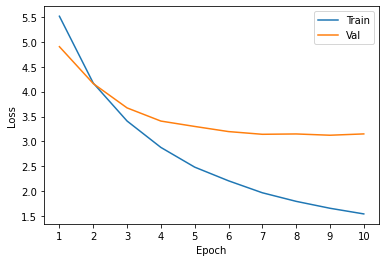

CPU times: user 39min 54s, sys: 41.7 s, total: 40min 36s
Wall time: 41min 5s


In [18]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'nmt-model-lstm-2L.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [20]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=2
save='nmt-model-lstm-2L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = i liked your idea and adopted it
Ground Truth    = me gustó tu idea y la adopté
Predicted Label = me gustó tu tu y me contuve

Source          = tom is very upset about this
Ground Truth    = tom está muy disgustado por esto
Predicted Label = tom está muy preocupado por esto

Source          = would you please take my picture
Ground Truth    = podría sacarme una foto por favor
Predicted Label = me soltarías mi foto

Source          = he is one of my neighbours
Ground Truth    = él es uno de mis vecinos
Predicted Label = él es uno de mis parientes

Source          = he looks as if he had been ill
Ground Truth    = parece como si hubiese estado enfermo
Predicted Label = él se sentía que enfermo enfermo

Source          = our refrigerator is out of order
Ground Truth    = nuestro frigorífico está estropeado
Predicted Label = nuestro refrigerador está descompuesto

Source          = i want you to do me a favor
Ground Truth    = quiero que me hagas un favor
Predicted Labe

## Modelo 2

#### Entrenamiento

100%|██████████| 382/382 [04:40<00:00,  1.36 batches/s, epoch=10, train loss= 1.835, val loss= 3.3343]                                                                                                  


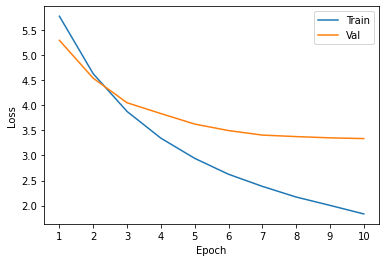

CPU times: user 45min 46s, sys: 47.5 s, total: 46min 34s
Wall time: 46min 54s


In [21]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 3
save = 'nmt-model-lstm-3L.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [22]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=3
save='nmt-model-lstm-3L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = i liked your idea and adopted it
Ground Truth    = me gustó tu idea y la adopté
Predicted Label = me valoro tu camisa y teléfono

Source          = tom is very upset about this
Ground Truth    = tom está muy disgustado por esto
Predicted Label = tom está muy preocupado por esto

Source          = would you please take my picture
Ground Truth    = podría sacarme una foto por favor
Predicted Label = podrías mi mi foto

Source          = he is one of my neighbours
Ground Truth    = él es uno de mis vecinos
Predicted Label = él es uno de mis vecinos

Source          = he looks as if he had been ill
Ground Truth    = parece como si hubiese estado enfermo
Predicted Label = él se siente si si hubiera estado enfermo

Source          = our refrigerator is out of order
Ground Truth    = nuestro frigorífico está estropeado
Predicted Label = nuestro reja está descompuesto

Source          = i want you to do me a favor
Ground Truth    = quiero que me hagas un favor
Predicted Labe

## Modelo 3
### Transferencia de conocimiento


#### Entrenamiento

100%|██████████| 382/382 [04:05<00:00,  1.56 batches/s, epoch=10, train loss= 1.537, val loss= 3.1555]                                                                                                  


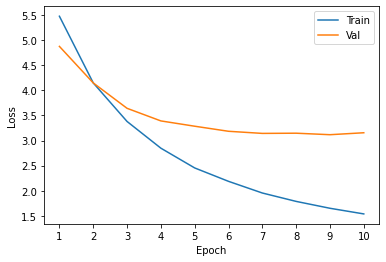

CPU times: user 40min 17s, sys: 48.9 s, total: 41min 6s
Wall time: 41min 23s


In [10]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'nmt-model-lstm-glove-2L.pth'
embedding="glove.42B.300d"
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

#### Inferencia

In [11]:
embedding_dim = 300
hidden_dim = 1024
dropout = 0.5
layers=2
save='nmt-model-lstm-glove-2L.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = i liked your idea and adopted it
Ground Truth    = me gustó tu idea y la adopté
Predicted Label = me gusta tu concepto de tu profesor

Source          = tom is very upset about this
Ground Truth    = tom está muy disgustado por esto
Predicted Label = tom está muy preocupado por esto

Source          = would you please take my picture
Ground Truth    = podría sacarme una foto por favor
Predicted Label = me soltarías mi foto

Source          = he is one of my neighbours
Ground Truth    = él es uno de mis vecinos
Predicted Label = es uno de mis vecinos

Source          = he looks as if he had been ill
Ground Truth    = parece como si hubiese estado enfermo
Predicted Label = él se si si hubiera sido enfermo

Source          = our refrigerator is out of order
Ground Truth    = nuestro frigorífico está estropeado
Predicted Label = nuestro refrigerador está descompuesto

Source          = i want you to do me a favor
Ground Truth    = quiero que me hagas un favor
Predicted L

## Modelo 4

100%|██████████| 382/382 [04:12<00:00,  1.51 batches/s, epoch=10, train loss= 1.4014, val loss= 3.1087]                                                                                                 


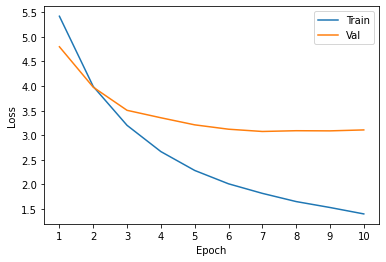

CPU times: user 41min 12s, sys: 48.3 s, total: 42min 1s
Wall time: 42min 17s


In [13]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'nmt-model-lstm-glove-2L-512.pth'
embedding=False
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

In [14]:
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers=2
save='nmt-model-lstm-glove-2L-512.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = i liked your idea and adopted it
Ground Truth    = me gustó tu idea y la adopté
Predicted Label = me gustó tu actitud y y la

Source          = tom is very upset about this
Ground Truth    = tom está muy disgustado por esto
Predicted Label = tom está muy emocionado con esto

Source          = would you please take my picture
Ground Truth    = podría sacarme una foto por favor
Predicted Label = podrías usted mi foto

Source          = he is one of my neighbours
Ground Truth    = él es uno de mis vecinos
Predicted Label = él es uno de mis sueños

Source          = he looks as if he had been ill
Ground Truth    = parece como si hubiese estado enfermo
Predicted Label = él se siente enfermo como hubiera estado enfermo

Source          = our refrigerator is out of order
Ground Truth    = nuestro frigorífico está estropeado
Predicted Label = nuestro reja está descompuesto

Source          = i want you to do me a favor
Ground Truth    = quiero que me hagas un favor
Predicted

## Modelo 5

100%|██████████| 382/382 [04:17<00:00,  1.49 batches/s, epoch=10, train loss= 1.3355, val loss= 3.0892]                                                                                                 


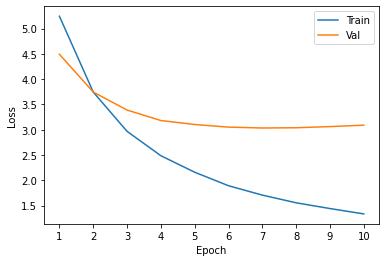

CPU times: user 41min 17s, sys: 1min 39s, total: 42min 57s
Wall time: 43min 16s


In [15]:
%%time
# Define the required dimensions and hyper parameters
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers = 2
save = 'nmt-model-lstm-glove-2L-512-glove.pth'
embedding="glove.42B.300d"
train_iterator, valid_iterator, test_iterator, source, target = get_datasets(batch_size=300, embedding=embedding)
model = train(train_iterator, valid_iterator, source, target, save, epochs=10)

In [16]:
embedding_dim = 512
hidden_dim = 1024
dropout = 0.5
layers=2
save='nmt-model-lstm-glove-2L-512-glove.pth'
model, source_vocab, target_vocab, test_data = load_models_and_test_data(save)
show_prediction(model, source_vocab, target_vocab, test_data, n_examples=20)


Source          = i liked your idea and adopted it
Ground Truth    = me gustó tu idea y la adopté
Predicted Label = me gustó tu idea y hace la idea

Source          = tom is very upset about this
Ground Truth    = tom está muy disgustado por esto
Predicted Label = tom está muy entusiasmado por esto

Source          = would you please take my picture
Ground Truth    = podría sacarme una foto por favor
Predicted Label = me pasarías mi foto por teléfono

Source          = he is one of my neighbours
Ground Truth    = él es uno de mis vecinos
Predicted Label = él es uno de mis pasatiempos

Source          = he looks as if he had been ill
Ground Truth    = parece como si hubiese estado enfermo
Predicted Label = él se enfermo si hubiera estado enfermo

Source          = our refrigerator is out of order
Ground Truth    = nuestro frigorífico está estropeado
Predicted Label = nuestro refrigerador está averiado

Source          = i want you to do me a favor
Ground Truth    = quiero que me hagas 